In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
dataFrame = pd.read_csv('data/global-food.csv')


In [3]:
dfFood = dataFrame.query('Year==2018')[['Country', 'Food supply (Fat g per capita per day)', 'Food supply (Protein g per capita per day)', 'Food supply (kcal per capita per day)']]
dfFood.index = range(dfFood.shape[0])
dfFood.columns = ['Country', 'Fat', 'Protein', 'Calories']
dfFood.head()

,Country,Fat,Protein,Calories
0,Afghanistan,31.910000,55.520000,2040.000000
1,Africa,54.340333,68.112344,2604.253905
2,Albania,116.750000,115.739998,3360.000000
3,Algeria,77.279999,91.830002,3322.000000
4,Angola,57.730000,53.049999,2385.000000


In [4]:
dataFrame = pd.read_csv('data/gdp-per-capita.csv',)

dfGDP = dataFrame.query('Year==2018')[['Entity', 'GDP per capita, PPP (constant 2017 international $)']]
dfGDP.columns = ['Country', 'GDP']
dfGDP.index = range(dfGDP.shape[0])


In [5]:
dataFrame = dfGDP.join(dfFood.set_index('Country'), on='Country')
dataFrame.dropna(axis='index', inplace=True)
dataFrame.index = range(dataFrame.shape[0])
dataFrame

,Country,GDP,Fat,Protein,Calories
0,Afghanistan,2033.804443,31.910000,55.520000,2040.000000
1,Albania,13317.092773,116.750000,115.739998,3360.000000
2,Algeria,11630.679688,77.279999,91.830002,3322.000000
3,Angola,6933.500000,57.730000,53.049999,2385.000000
4,Antigua and Barbuda,21017.263672,91.480003,80.190002,2445.000000
...,...,...,...,...,...
162,Vanuatu,3093.461426,101.339996,63.950001,2607.000000
163,Vietnam,7585.943359,87.540001,98.580002,3025.000000
164,World,16607.765625,86.140326,82.865269,2928.399523
165,Zambia,3521.545898,48.459999,60.529999,2002.000000


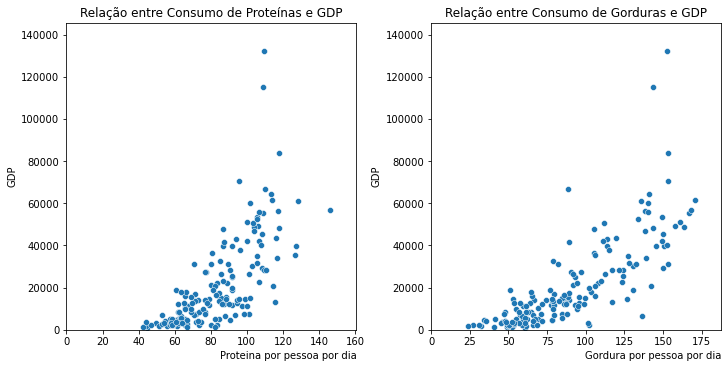

In [6]:
fig = plt.figure(constrained_layout=True)
gs = GridSpec(1, 2, figure=fig)
fig.set_size_inches(10,5)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])


ax0.set_title('Relação entre Consumo de Proteínas e GDP', fontsize=12)
ax0.set_xlabel('Proteina por pessoa por dia', loc='right', fontsize=10)
ax0.set_ylabel('GDP', loc='center', fontsize=10)

ax0.set_xlim(xmin=0, xmax=(dataFrame.Protein.max() * 1.1))
ax0.set_ylim(ymin=0, ymax=(dataFrame.GDP.max() * 1.1))

sns.scatterplot(data=dataFrame, x='Protein', y='GDP', ax=ax0)


ax1.set_title('Relação entre Consumo de Gorduras e GDP', fontsize=12)
ax1.set_xlabel('Gordura por pessoa por dia', loc='right', fontsize=10)

ax1.set_xlim(xmin=0, xmax=(dataFrame.Fat.max() * 1.1))
ax1.set_ylim(ymin=0, ymax=(dataFrame.GDP.max() * 1.1))

sns.scatterplot(data=dataFrame, x='Fat', y='GDP', ax=ax1)


plt.show()

In [7]:
dataFrame.corr()

,GDP,Fat,Protein,Calories
GDP,1.000000,0.778344,0.707403,0.683274
Fat,0.778344,1.000000,0.809317,0.831830
Protein,0.707403,0.809317,1.000000,0.890008
Calories,0.683274,0.831830,0.890008,1.000000


In [86]:
def poly_feat(deg : int, str_Independente : str) :
    poly = PolynomialFeatures(degree=deg)
    protein_poly = poly.fit_transform(dataFrame[[str_Independente]])
    dfProteinPoly = pd.DataFrame(protein_poly)
    
    indep = []

    for i in range(deg + 1):
      indep.append(f'{str_Independente}_{i}')  
    
    dfProteinPoly.columns = indep
    
    return dfProteinPoly

In [85]:
def nl_pred(dataFrame : pd.DataFrame, deg : int, str_Independente : str) :
    
    dfProteinPoly = poly_feat(deg, str_Independente)
    
    independentes = []
    
    for i in range(deg + 1):
      dataFrame[f'{str_Independente}_{i}'] = dfProteinPoly[f'{str_Independente}_{i}']
      independentes.append(f'{str_Independente}_{i}')
    
    X_train, X_test, y_train, y_test = train_test_split(dataFrame[independentes], dataFrame.GDP, test_size=0.33, random_state=1234)
    lr = LinearRegression().fit(X=X_train, y=y_train) 
    gdp_pred = lr.predict(X_test)
    gdp_real = y_test
    r2 = lr.score(X_test, y_test)
    mse = mean_squared_error(gdp_real, gdp_pred).round(2)
    rmse = np.sqrt(mean_squared_error(gdp_real, gdp_pred)).round(2)
    gdp_mean = np.round(np.mean(gdp_real), 2)
    err_pct = np.round(np.sqrt(mse) / gdp_mean * 100, 2)
    return r2, mse, rmse, gdp_mean, err_pct



In [89]:
for grau in range(6) :
    r2, mse, rmse, gdp_mean, err_pct = nl_pred(dataFrame, grau, 'Protein')
    print(f'Grau: {grau} - Coeficiente de Determinação :{r2.round(5)} - Erro Percentual: {err_pct}%.')


Grau: 0 - Coeficiente de Determinação :-0.06097 - Erro Percentual: 100.07%.
Grau: 1 - Coeficiente de Determinação :0.54002 - Erro Percentual: 65.89%.
Grau: 2 - Coeficiente de Determinação :0.54485 - Erro Percentual: 65.54%.
Grau: 3 - Coeficiente de Determinação :0.57732 - Erro Percentual: 63.16%.
Grau: 4 - Coeficiente de Determinação :0.10623 - Erro Percentual: 91.84%.
Grau: 5 - Coeficiente de Determinação :-0.48627 - Erro Percentual: 118.44%.


In [38]:
nl_pred(dataFrame, 1, 'Protein')

(0.54, 141329427.95, 11888.21, 18042.85, 65.89)

,0,1,2
0,1.0,55.520000,3082.470451
1,1.0,115.739998,13395.747106
2,1.0,91.830002,8432.749236
3,1.0,53.049999,2814.302419
4,1.0,80.190002,6430.436492
...,...,...,...
162,1.0,63.950001,4089.602598
163,1.0,98.580002,9718.016761
164,1.0,82.865269,6866.652820
165,1.0,60.529999,3663.880752


In [ ]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log2, validate=True)


fat_poly = transformer.fit_transform(dataFrame[['Fat']])
protein_poly = transformer.fit_transform(dataFrame[['Protein']])
dfFatPoly = pd.DataFrame(fat_poly)

dfProteinPoly


dataFrame['Protein_log'] = dfProteinPoly.loc[:,0]
dataFrame['Fat_log'] = dfFatPoly.loc[:,0]
dataFrame  

In [ ]:
r2, mse, rmse, gdp_mean, err_pct = nl_pred(dataFrame, 'Protein_log', 'Fat_log')
print(f'Coeficiente de Determinação :{r2}.')
print(f'Erro médio quadrático : {mse}.')
print(f'Raiz do Erro médio quadrático : {rmse}.')
print(f'Media da GDP: {gdp_mean}')
print(f'Erro percentual do preditor: {err_pct}%')

In [ ]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)

deg = 2
poly = PolynomialFeatures(degree=deg)
fat_poly = poly.fit_transform(dataFrame[['Fat']])
protein_poly = poly.fit_transform(dataFrame[['Protein']])
dfFatPoly = pd.DataFrame(fat_poly)
dfProteinPoly = pd.DataFrame(protein_poly)
dfProteinPoly

indep = []

for i in range(deg + 1):
  dataFrame[f'Protein_deg_{i}'] = dfProteinPoly.loc[:,i]
  dataFrame[f'Fat_deg_{i}'] = dfFatPoly.loc[:,i]
  indep.append(f'Fat_deg_{i}')
  indep.append(f'Protein_deg_{i}')
  
r2, mse, rmse, gdp_mean, err_pct = nl_pred(dataFrame, indep)
print(f'Coeficiente de Determinação :{r2}.')
    

# for i in range(deg + 1):
#    for j in range(deg + 1):
#        r2, mse, rmse, gdp_mean, err_pct = nl_pred(dataFrame, f'Protein_deg_{i}', f'Fat_deg_{j}')
#        print(f'GRAU P:{i} F:{j}:')
#        print(f'Coeficiente de Determinação :{r2}.')
#        print(f'Erro médio quadrático : {mse}.')
#        print(f'Raiz do Erro médio quadrático : {rmse}.')
#        print(f'Media da GDP: {gdp_mean}')
#        print(f'Erro percentual do preditor: {err_pct}%')

